In [1]:
import pandas_datareader.data as web
from datetime import datetime, date
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import numpy as np
%matplotlib inline 
import statsmodels.api as sm
import os

pd.set_option('display.max_columns', None)


In [2]:
PROJECT_DIR = os.getcwd()
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR) 

In [49]:
def get_risk_free_rate():
    """
    Obtiene el tipo de interés libre de riesgo (T-Bill 3M, ticker ^IRX) desde Yahoo Finance.
    Devuelve el valor diario equivalente (no anual).
    """
    t_bill = yf.Ticker("^IRX")
    data = t_bill.history(period="5d")  # últimos 5 días para evitar problemas de días festivos
    last_yield = data["Close"].iloc[-1] / 100.0  # convertir % a decimal
    
    # Pasar de anual a diario (252 días de mercado al año)
    risk_free_daily = (1 + last_yield) ** (1/252) - 1
    return risk_free_daily

def save_extraction_historic_parquet(data_his, path="data_historic"):
    os.makedirs(SUBFOLDER_DIR, exist_ok=True)
    for name, df in ibex35_df.items():
        df['share_name'] = name
        filename = name.lower().replace(' ', '_')
        df.to_parquet(f"{path}//{filename}.parquet", index=True)

def load_extraction_historic_parquet(path="data_historic"):
    data_his = {}
    for file in os.listdir(path):
        if file.endswith(".parquet"):
            name = file.replace(".parquet", "")
            df = pd.read_parquet(os.path.join(path, file))
            data_his[name] = df
    return data_his
    
def compute_sharpe_ratio(data, risk_free_rate = 0):
    mean_return = data["Daily Return"].mean()
    std = data["Daily Return"].std()
    sharpe_ratio = (mean_return-risk_free_rate) / std
    return sharpe_ratio

def compute_alpha_beta(stock_data, benchmark_data):
    """
    Calcula Alpha y Beta de un activo respecto a un benchmark.
    stock_data y benchmark_data deben ser Series con retornos diarios (%).
    """
    # Alinear índices de fechas
    data = pd.merge(
        stock_data.rename("stock"),
        benchmark_data.rename("benchmark"),
        left_index=True,
        right_index=True,
        how="left"
    ).dropna()

    stock_returns = data.iloc[:, 0].pct_change(1).dropna()
    benchmark_returns = data.iloc[:, 1].pct_change(1).dropna()

    # Regresión lineal: stock = alpha + beta * benchmark
    X = sm.add_constant(benchmark_returns)
    model = sm.OLS(stock_returns, X).fit()
    alpha, beta = model.params

    return alpha, beta

def call_yf_api_historic(start_period, end_period, ticker):
    data = yf.download(ticker, start_period , end_period, auto_adjust=True)
    data.columns = data.columns.droplevel('Ticker')
    data["Daily Return"] = data["Close"].pct_change(1)
    data = data.dropna()
    data["Cumulative Return"] = (1 + data["Daily Return"]).cumprod() - 1
    return data

def extraction_historic(start_period, end_period, tickers):
    data_his = {}
    
    for ticker in tqdm(tickers, desc="Procesando tickers"):
        name_ticker = tickers[ticker]
        data_his[name_ticker] = call_yf_api_historic(start_period, end_period, ticker)
    return data_his

def interpretar_recomendacion(val):
    if val is None:
        return None
    elif val < 1.5:
        return "Compra fuerte (Strong Buy)"
    elif val < 2.5:
        return "Compra (Buy)"
    elif val < 3.5:
        return "Mantener (Hold)"
    elif val < 4.5:
        return "Vender (Underperform / Sell)"
    else:
        return "Vender fuerte (Strong Sell)"

def interpretar_sharpe(sharpe):
    if sharpe is None or pd.isna(sharpe):
        return None
    elif sharpe < 0:
        return "Mala inversión (rinde peor que activo libre de riesgo)"
    elif sharpe < 1:
        return "Rentabilidad baja para el riesgo asumido"
    elif sharpe < 2:
        return "Aceptable"
    elif sharpe < 3:
        return "Buena"
    else:
        return "Excelente"
        
# Valores posibles:
    
# 👉 En teoría: puede ser cualquier número real (positivo, negativo o cercano a cero).
# 🔴 < 0 → la inversión rinde peor que un activo libre de riesgo (mala señal).
# 🟠 0 – 1 → rentabilidad baja respecto al riesgo, poco atractivo.
# 🟡 1 – 2 → inversión aceptable/buena.
# 🟢 2 – 3 → inversión muy buena.
# 🟢 > 3 → inversión excelente (pocas veces se da en mercados reales).
def analysis_stock_hist(df_raw, tickers, bechmark_df):
    rows = []

    for name, df in tqdm(df_raw.items(), desc="Procesando tickers"):
        ticker = next((k for k, v in tickers.items() if v == name), None)
        if ticker is None or df.empty:
            continue
            # Fechas de referencia
        end_date = df.index[-1]
        one_month_ago = end_date - pd.DateOffset(months=1)
        two_months_ago = end_date - pd.DateOffset(months=2)
        three_months_ago = end_date - pd.DateOffset(months=3)
        
        # Filtramos precios desde esas fechas más cercanas
        price_now = df["Close"].iloc[-1]
        price_1m_ago = df[df.index >= one_month_ago]["Close"].iloc[0]
        price_2m_ago = df[df.index >= two_months_ago]["Close"].iloc[0]
        price_3m_ago = df[df.index >= three_months_ago]["Close"].iloc[0]
        
        # Calculamos retornos acumulados
        ret_1m = ((price_now / price_1m_ago) - 1 ) * 100
        ret_2m = ((price_now / price_2m_ago) - 1 ) * 100
        ret_3m = ((price_now / price_3m_ago) - 1 ) * 100

        # # Retornos seguros
        # ret_1m = df["Cumulative Return"].iloc[-1]
        # ret_2m = df["Cumulative Return"].iloc[max(0, len(df)-31)]
        # ret_3m = df["Cumulative Return"].iloc[max(0, len(df)-61)]

        df["Daily Return"] = df["Close"].pct_change()
        volatilidad = df["Daily Return"].std()
        precio_actual = df["Close"].iloc[-1]

        # Datos de Yahoo Finance
        company_data = yf.Ticker(ticker).info
        sector = company_data.get("sector")
        industry = company_data.get("industry")
        market_cap = company_data.get("marketCap")
        recommendation = company_data.get("recommendationMean")
        target_price = company_data.get("targetMeanPrice")
        recommendation_interpratation = interpretar_recomendacion(recommendation)

        sharpe_ratio = compute_sharpe_ratio(df)
        sharpe_interpretation = interpretar_sharpe(sharpe_ratio)
        alpha, beta_calculated = compute_alpha_beta(df["Close"], bechmark_df["Close"])

        dividend_yield = company_data.get("dividendYield")
        pe_trailing = company_data.get("trailingPE")
        pe_forward = company_data.get("forwardPE")
        pb = company_data.get("priceToBook")
        volume = company_data.get("volume")
        beta = company_data.get("beta")  # corregido

        # ➕ Nuevo: próximo dividendo
        timestamp = company_data.get("exDividendDate")
        ex_dividend_date = datetime.fromtimestamp(timestamp).date() if timestamp else None
        dividend_rate = company_data.get("dividendRate")       # dividendo anual
        # Si es trimestral aproximamos cantidad por acción
        next_dividend = round(dividend_rate / 4, 4) if dividend_rate else None

        rentabilidad_prevista = round((target_price-precio_actual) / precio_actual * 100, 1) if target_price else None

        rows.append({
            "Empresa": name,
            "Ticker": ticker,
            "Sector": sector,
            "Industria": industry,
            "Capitalización mercado": market_cap,
            "Retorno 1 mes": ret_1m,
            "Retorno 2 meses": ret_2m,
            "Retorno 3 meses": ret_3m,
            "Precio actual": precio_actual,
            "Precio objetivo analistas": target_price,
            "Rentabilidad prevista": rentabilidad_prevista,
            "Valoración analistas": recommendation,
            "Interpretacion recomendacion": recommendation_interpratation,
            "sharpe_ratio": sharpe_ratio,
            "Interpretacion Sharpe": sharpe_interpretation,
            "volatilidad": volatilidad,
            "alpha": alpha, 
            "beta_calculada": beta_calculated,
            "Dividend Yield": dividend_yield,
            "P/E (Trailing)": pe_trailing,
            "P/E (Forward)": pe_forward,
            "P/B": pb,
            "Volumen": volume,
            "beta": beta,
            # ➕ Añadido dividendos
            "Ex-Dividend Date": ex_dividend_date,
            "Next Dividend": next_dividend,
        })

    df_ranking = pd.DataFrame(rows)
    return df_ranking.sort_values('Rentabilidad prevista', ascending=False, na_position='last')

def get_total_rank(df, rank_name, weight):
    if len(weight) == 3:
        df["Peso_PE"] = (1 / df["P/E (Trailing)"]) / (1 / df["P/E (Trailing)"]).sum() * weight[0]
        
        df["Peso_DY"] = (df["Dividend Yield"] / df["Dividend Yield"].sum()) * weight[1]
        
        df["Peso_PB"] = (1 / df["P/B"]) / (1 / df["P/B"]).sum() * weight[2]
        # 🔹 Sumatorio total
        df[rank_name] = (
            df["Peso_PE"] +
            df["Peso_DY"] +
            df["Peso_PB"]
        )
        df.drop(columns=["Peso_PE", "Peso_DY", "Peso_PB"], inplace=True)
    else:
        print('No correct shape')
    return df

        


In [21]:
len(weight)

3

In [4]:
get_risk_free_rate()

0.000145256190434484

In [5]:
ticker = yf.Ticker("AAPL")  # ejemplo
dividends = ticker.dividends  # devuelve un Series: índice = fecha, valor = dividendo por acción
print(dividends.tail(10))

info = ticker.info
print(info.get("dividendRate"))       # dividendo anual
print(info.get("dividendYield"))      # yield
print(info.get("exDividendDate"))     # fecha ex-dividendo (a partir de la cual compras no dan derecho al dividendo)

Date
2023-05-12 00:00:00-04:00    0.24
2023-08-11 00:00:00-04:00    0.24
2023-11-10 00:00:00-05:00    0.24
2024-02-09 00:00:00-05:00    0.24
2024-05-10 00:00:00-04:00    0.25
2024-08-12 00:00:00-04:00    0.25
2024-11-08 00:00:00-05:00    0.25
2025-02-10 00:00:00-05:00    0.25
2025-05-12 00:00:00-04:00    0.26
2025-08-11 00:00:00-04:00    0.26
Name: Dividends, dtype: float64
1.04
0.38
1762732800


In [6]:
info.get("dividendRate")

1.04

In [7]:
start_period = datetime(2025,1,1)
end_period =  datetime(2025,9,11)
ibex35_tickers = {
    "ANA.MC":  "Acciona",
    "ANE.MC":  "Acciona Energía",
    "ACX.MC":  "Acerinox",
    "ACS.MC":  "ACS",
    "AENA.MC": "Aena",
    "AMS.MC":  "Amadeus",
    "BBVA.MC": "BBVA",
    "BKT.MC":  "Bankinter",
    "CABK.MC": "CaixaBank",
    "CLNX.MC": "Cellnex Telecom",
    "COL.MC":  "Inmobiliaria Colonial",
    "ELE.MC":  "Endesa",
    "ENG.MC":  "Enagás",
    "FDR.MC":  "Fluidra",
    "FER.MC":  "Ferrovial",
    "GRF.MC":  "Grifols",
    "IAG.MC":  "IAG (International Airlines Group)",
    "IBE.MC":  "Iberdrola",
    "IDR.MC":  "Indra",
    "ITX.MC":  "Inditex",
    "LOG.MC":  "Logista",
    "MAP.MC":  "Mapfre",
    "MEL.MC":  "Meliá Hotels International",
    "MRL.MC":  "Merlin Properties",
    "MTS.MC":  "ArcelorMittal",
    "NTGY.MC": "Naturgy",
    "PUIG.MC": "Puig",
    "RED.MC":  "Redeia",
    "REP.MC":  "Repsol",
    "ROVI.MC": "Rovi",
    "SAB.MC":  "Banco Sabadell",
    "SAN.MC":  "Banco Santander",
    "SCYR.MC": "Sacyr",
    "SLR.MC":  "Solaria",
    "TEF.MC":  "Telefónica",
    "UNI.MC":  "Unicaja Banco"
}
bechmark_ibex35 = call_yf_api_historic(start_period, end_period, '^IBEX')
ibex35_df = extraction_historic(start_period, end_period, ibex35_tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed                                                                                                                                | 0/36 [00:00<?, ?it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 1/36 [00:00<00:08,  4.09it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 2/36 [00:00<00:07,  4.49it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 3/36 [00:00<00:07,  4.37it/s]
[*********************100%***********************] 

In [47]:
ibex35_analysed_df = analysis_stock_hist(ibex35_df, ibex35_tickers, bechmark_ibex35)

Procesando tickers: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:21<00:00,  1.65it/s]


In [51]:
# Normalización ponderada corregida
weight = [80,40,20]
weight = [30,70,30]

ibex35_analysed_df = get_total_rank(ibex35_analysed_df, 'rank_per', [80,40,20])
ibex35_analysed_df = get_total_rank(ibex35_analysed_df, 'rank_dividend', [30,70,30])

# 🔹 Ranking descendente (mejor empresa = mayor puntuación)
ibex35_analysed_df = ibex35_analysed_df.sort_values(by="rank_per", ascending=False)
ibex35_filename = os.path.join(DATA_DIR, 'ibex35_analysed_df.csv')
ibex35_analysed_df.to_csv(ibex35_filename, index=False)

In [52]:
ibex35_analysed_df.head(30)

,Empresa,Ticker,Sector,Industria,Capitalización mercado,Retorno 1 mes,Retorno 2 meses,Retorno 3 meses,Precio actual,Precio objetivo analistas,Rentabilidad prevista,Valoración analistas,Interpretacion recomendacion,sharpe_ratio,Interpretacion Sharpe,volatilidad,alpha,beta_calculada,Dividend Yield,P/E (Trailing),P/E (Forward),P/B,Volumen,beta,Ex-Dividend Date,Next Dividend,rank_per,rank_dividend
10,Inmobiliaria Colonial,COL.MC,Real Estate,REIT - Office,3365938432,-3.921561,-4.572396,-5.767694,5.635000,7.01444,24.5,2.05556,Compra (Buy),0.061717,Rentabilidad baja para el riesgo asumido,0.013529,-0.000200,0.650703,5.44,7.123377,16.621212,0.586631,779209.0,1.468,2025-06-17,0.0750,7.847561,7.007464
30,Banco Sabadell,SAB.MC,Financial Services,Banks - Diversified,16206558208,2.964821,14.230349,23.335951,3.364000,3.34233,-0.6,2.20000,Compra (Buy),0.201995,Rentabilidad baja para el riesgo asumido,0.019570,0.001736,1.394033,6.38,9.008333,24.946156,1.186608,9700002.0,0.817,2025-12-23,0.0500,6.362727,5.934625
35,Unicaja Banco,UNI.MC,Financial Services,Banks - Regional,6009623552,-0.833334,14.093959,22.617212,2.311704,2.25667,-2.4,3.11111,Mantener (Hold),0.210574,Rentabilidad baja para el riesgo asumido,0.018984,0.002055,1.221542,5.95,9.750000,15.599998,0.861561,15871944.0,0.642,2025-09-23,0.0350,6.253283,6.049219
25,Naturgy,NTGY.MC,Utilities,Utilities - Regulated Gas,25241772032,-0.908402,-1.240074,1.996722,26.180000,26.48000,1.1,3.43750,Mantener (Hold),0.068730,Rentabilidad baja para el riesgo asumido,0.011808,0.000182,0.395651,9.03,11.891403,18.771430,2.663964,2684660.0,0.630,2025-07-28,0.6000,5.846683,6.353904
16,IAG (International Airlines Group),IAG.MC,Industrials,Airlines,21864165376,2.361663,3.005596,11.008962,4.421000,5.24000,18.5,1.70000,Compra (Buy),0.064698,Rentabilidad baja para el riesgo asumido,0.024008,-0.000552,1.323857,1.91,7.329231,4.037288,3.736471,6614799.0,1.808,2025-06-26,0.0225,5.301932,3.066741
24,ArcelorMittal,MTS.MC,Basic Materials,Steel,25361258496,3.870515,-0.236565,10.769234,29.520000,34.00000,15.2,2.00000,Compra (Buy),0.085907,Rentabilidad baja para el riesgo asumido,0.025542,0.000141,1.291311,1.57,11.804270,7.573059,0.463890,123468.0,1.711,2025-11-12,0.1300,5.271568,4.902677
21,Mapfre,MAP.MC,Financial Services,Insurance - Diversified,11737122816,3.270777,9.307607,15.053762,3.852000,3.44500,-10.6,3.00000,Mantener (Hold),0.181191,Rentabilidad baja para el riesgo asumido,0.015531,0.001303,0.950266,4.72,10.948571,16.660870,1.310086,6661444.0,0.506,2025-05-27,0.0475,5.140075,4.700153
6,BBVA,BBVA.MC,Financial Services,Banks - Diversified,100366647296,0.560399,20.973776,22.487669,16.150000,17.44833,8.0,2.05882,Compra (Buy),0.176878,Rentabilidad baja para el riesgo asumido,0.020198,0.001231,1.472509,4.22,9.906250,18.547873,1.822601,9575520.0,NaN,2025-11-05,0.1825,5.102404,4.251371
8,CaixaBank,CABK.MC,Financial Services,Banks - Regional,64365260800,1.858314,15.943949,18.513518,8.770000,9.09600,3.7,2.40000,Compra (Buy),0.178915,Rentabilidad baja para el riesgo asumido,0.019112,0.001252,1.362943,4.82,11.311110,22.346340,1.730638,9683674.0,0.526,2025-04-22,0.1100,4.900751,4.456695
20,Logista,LOG.MC,Industrials,Integrated Freight & Logistics,3817580544,1.412992,5.489894,3.121001,28.820000,31.63100,9.8,2.30000,Compra (Buy),0.029450,Rentabilidad baja para el riesgo asumido,0.011680,-0.000435,0.489965,7.22,13.388888,14.107317,5.885226,99661.0,0.471,2025-08-26,0.5225,4.797009,4.988962


In [12]:
tickers_sp500 = {
    "AAPL": "Apple Inc.",        "MSFT": "Microsoft Corporation",     "NVDA": "NVIDIA Corporation",
    "GOOGL": "Alphabet Inc. (Clase A)", "AMZN": "Amazon.com, Inc.",   "META": "Meta Platforms, Inc.",
    "TSLA": "Tesla, Inc.",       "BRK-B": "Berkshire Hathaway Inc.",  "JPM": "JPMorgan Chase & Co.",
    "V": "Visa Inc.",            "LLY": "Eli Lilly and Co.",          "JNJ": "Johnson & Johnson",
    "PG": "Procter & Gamble Co.", "UNH": "UnitedHealth Group Inc.",   "HD": "Home Depot, Inc.",
    "ABBV": "AbbVie Inc.",       "BAC": "Bank of America Corp.",      "KO": "Coca-Cola Company",
    "PEP": "PepsiCo, Inc.",      "CRM": "Salesforce, Inc.",           "ORCL": "Oracle Corporation",
    "CSCO": "Cisco Systems, Inc.","TMO": "Thermo Fisher Scientific",  "QCOM": "Qualcomm Inc.",
    "ADBE": "Adobe Inc.",        "INTC": "Intel Corporation",         "TXN": "Texas Instruments Inc.",
    "BLK": "BlackRock, Inc.",    "LMT": "Lockheed Martin Corp.",      "ABT": "Abbott Laboratories",
    "CAT": "Caterpillar Inc.",   "MRK": "Merck & Co., Inc.",          "AMGN": "Amgen Inc.",
    "MCD": "McDonald's Corp.",   "NKE": "Nike, Inc.",                 "XOM": "Exxon Mobil Corp.",
    "WMT": "Walmart Inc.",       "JCI": "Johnson Controls plc",       "GE": "General Electric Co.",
    "MMM": "3M Company",         "PFE": "Pfizer Inc.",                "CVS": "CVS Health Corp.",
    "CL": "Colgate-Palmolive",   "DIS": "Walt Disney Company",        "RTX": "RTX Corporation",
    "UBER": "Uber Technologies", "NOW": "ServiceNow, Inc.",           "SPGI": "S&P Global Inc.",
    "MDT": "Medtronic plc",      "NEE": "NextEra Energy, Inc.",       "LOW": "Lowe's Companies, Inc.",
    "PYPL": "PayPal Holdings",   "INTU": "Intuit Inc.",               "ADP": "Automatic Data Processing",
    "ISRG": "Intuitive Surgical","AMT": "American Tower Corp.",       "CSX": "CSX Corporation",
    "DUK": "Duke Energy Corp.",  "AVGO": "Broadcom Inc.",             "GOOG": "Alphabet Inc. (Clase C)",
    "NFLX": "Netflix, Inc.",     "MA": "Mastercard Incorporated",     "COST": "Costco Wholesale Corp.",
}

bechmark_sp500 = call_yf_api_historic(start_period, end_period, '^GSPC')
sp500_df = extraction_historic(start_period, end_period, tickers_sp500)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed                                                                                                                                | 0/63 [00:00<?, ?it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 1/63 [00:00<00:16,  3.85it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 2/63 [00:00<00:15,  4.05it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 3/63 [00:00<00:13,  4.31it/s]
[*********************100%***********************] 

In [39]:
sp500_analysed_df = analysis_stock_hist(sp500_df, tickers_sp500, bechmark_sp500)

Procesando tickers: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:45<00:00,  1.38it/s]


In [42]:
sp500_analysed_df = get_total_rank(sp500_analysed_df, 'rank_per', [80,40,20])
sp500_analysed_df = get_total_rank(sp500_analysed_df, 'rank_dividend', [30,70,30])

In [45]:
# 🔹 Ranking descendente (mejor empresa = mayor puntuación)
sp500_analysed_df = sp500_analysed_df.sort_values(by="rank_per", ascending=False)
sp500_filename = os.path.join(DATA_DIR, 'sp500_analysed_df.csv')
sp500_analysed_df.to_csv(sp500_filename, index=False)
sp500_analysed_df.head(50)

,Empresa,Ticker,Sector,Industria,Capitalización mercado,Retorno 1 mes,Retorno 2 meses,Retorno 3 meses,Precio actual,Precio objetivo analistas,Rentabilidad prevista,Valoración analistas,Interpretacion recomendacion,sharpe_ratio,Interpretacion Sharpe,volatilidad,alpha,beta_calculada,Dividend Yield,P/E (Trailing),P/E (Forward),P/B,Volumen,beta,Ex-Dividend Date,Next Dividend,rank_per,rank_dividend
40,Pfizer Inc.,PFE,Healthcare,Drug Manufacturers - General,139551834112,-0.040684,-3.049031,2.855808,24.570000,28.80864,17.3,2.43478,Compra (Buy),-0.001940,Mala inversión (rinde peor que activo libre de...,0.015881,-0.000320,0.447734,7.08,12.986773,8.377133,1.573196,91076640,0.465,2025-11-07,0.4300,5.396667,5.799491
31,"Merck & Co., Inc.",MRK,Healthcare,Drug Manufacturers - General,213960130560,4.998128,0.011912,4.328621,83.208069,101.92120,22.5,2.00000,Compra (Buy),-0.035863,Mala inversión (rinde peor que activo libre de...,0.018999,-0.000923,0.374457,3.76,11.330688,9.112766,4.674999,6416195,NaN,2025-09-15,0.8100,4.492466,3.687047
35,Exxon Mobil Corp.,XOM,Energy,Oil & Gas Integrated,488873787392,7.291744,-1.203466,5.900816,112.500000,126.65120,12.6,2.25000,Compra (Buy),0.033352,Rentabilidad baja para el riesgo asumido,0.016205,0.000162,0.586121,3.45,16.288593,14.570737,1.861705,11224408,0.484,2025-08-15,0.9900,3.455340,3.140818
16,Bank of America Corp.,BAC,Financial Services,Banks - Diversified,390438289408,9.204576,7.321339,11.796040,50.130001,58.10417,15.9,1.64000,Compra (Buy),0.050372,Rentabilidad baja para el riesgo asumido,0.018698,0.000271,1.039797,2.11,14.554645,14.554645,1.403652,18735526,1.334,2025-12-05,0.2800,3.192723,2.334467
57,Duke Energy Corp.,DUK,Utilities,Utilities - Regulated Electric,96557629440,-2.517481,3.578784,5.217093,121.349998,136.76471,12.7,2.18182,Compra (Buy),0.080677,Rentabilidad baja para el riesgo asumido,0.011415,0.000931,-0.015870,3.40,20.322422,19.585173,1.935258,1180432,0.424,2025-11-14,1.0650,3.016494,2.949222
8,JPMorgan Chase & Co.,JPM,Financial Services,Banks - Diversified,848046981120,3.791972,4.285369,12.430338,299.085938,326.45917,9.2,2.28000,Compra (Buy),0.088128,Rentabilidad baja para el riesgo asumido,0.016794,0.000828,1.011104,1.94,15.437562,18.609917,2.493038,4027920,1.127,2025-10-06,1.5000,2.985575,2.159367
29,Abbott Laboratories,ABT,Healthcare,Medical Devices,213916024832,-1.522537,-2.739028,-3.123347,128.787308,144.46616,12.2,1.75862,Compra (Buy),0.063139,Rentabilidad baja para el riesgo asumido,0.015061,0.000789,0.251390,1.89,15.474214,23.841085,4.234330,3520411,0.696,2025-10-15,0.5900,2.957632,2.118561
11,Johnson & Johnson,JNJ,Healthcare,Drug Manufacturers - General,454621954048,1.875675,12.296476,13.186517,175.789993,199.55522,13.5,2.16667,Compra (Buy),0.104048,Rentabilidad baja para el riesgo asumido,0.013424,0.001361,0.055104,2.75,18.249033,17.801414,5.727229,3252757,0.392,2025-11-25,1.3000,2.950698,2.571427
13,UnitedHealth Group Inc.,UNH,Healthcare,Healthcare Plans,307713376256,37.409368,15.782438,14.961567,344.605927,385.40000,11.8,2.00000,Compra (Buy),-0.046275,Mala inversión (rinde peor que activo libre de...,0.034599,-0.001761,0.247713,2.56,17.692709,11.361204,3.036832,5924151,0.478,2025-09-15,2.2100,2.939690,2.469894
51,PayPal Holdings,PYPL,Financial Services,Credit Services,64400924672,-2.146694,-13.289297,-12.199040,65.639999,83.33030,27.0,2.45455,Compra (Buy),-0.055245,Mala inversión (rinde peor que activo libre de...,0.024984,-0.002178,1.236628,0.82,13.821285,14.075665,3.206765,12677910,1.446,2025-11-19,0.1400,2.811571,1.497081


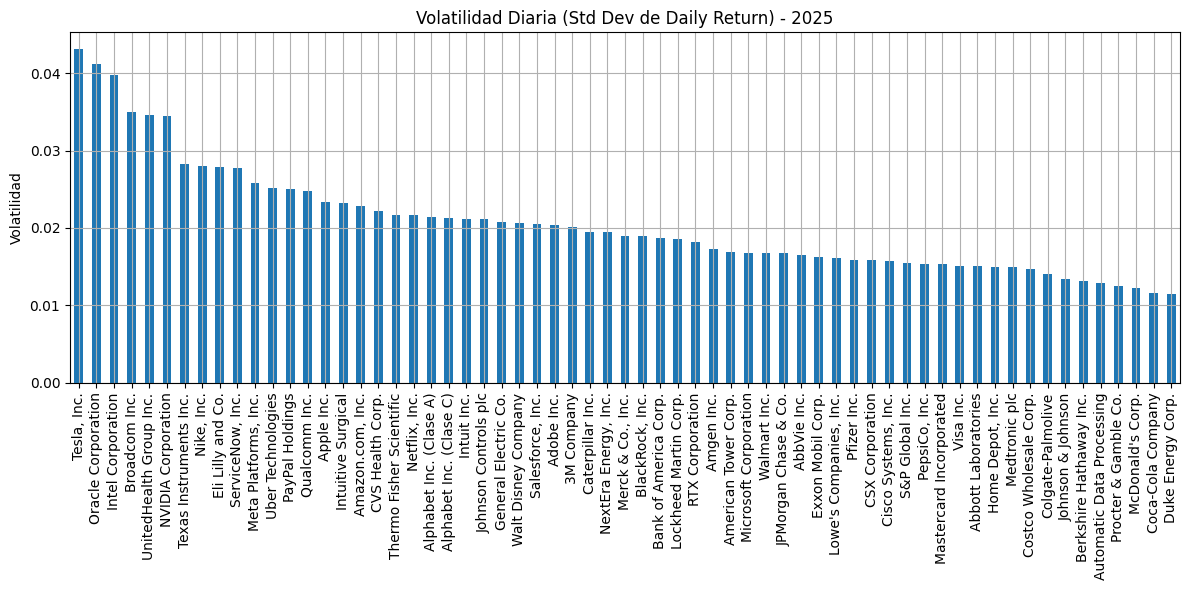

In [53]:
volatilities = {
    ticker: data["Daily Return"].std() for ticker, data in sp500_df.items()
}

# Convertir a DataFrame y graficar
vol_df = pd.DataFrame.from_dict(volatilities, orient='index', columns=["Volatilidad"])
vol_df.sort_values("Volatilidad", ascending=False).plot(kind='bar', figsize=(12, 6), legend=False)

plt.title("Volatilidad Diaria (Std Dev de Daily Return) - 2025")
plt.ylabel("Volatilidad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
start_period = datetime(2025,1,1)
end_period =  datetime(2025,10,31)

tickers_index = {
    "IWDA.AS": "MSCI World",
    "CSPX.AS": "S&P 500",
    "CS1.PA": "IBEX 35",
    "EUNK.DE": "Core MSCI Europe",
    "LYP6.DE": "Stoxx Europe 600",
    '^GSPC': "SP500 Index",
    '^IBEX': "IBEX35 Index",
    "GREK": "Global X MSCI Greece ETF",
    "EPOL": "iShares MSCI Poland ETF",
    "EWP": "iShares MSCI Spain ETF",
    # "AGG": "iShares Core U.S. Aggregate Bond ETF",        # renta fija diversificada USA (investment grade)
    # "BND": "Vanguard Total Bond Market ETF",              # mercado de bonos USA completo
    # "IEF": "iShares 7-10 Year Treasury Bond ETF",         # bonos del Tesoro USA medio plazo
    # "TLT": "iShares 20+ Year Treasury Bond ETF",          # bonos del Tesoro USA largo plazo
    # "LQD": "iShares iBoxx $ Investment Grade Corporate",  # bonos corporativos grado inversión
    # "HYG": "iShares iBoxx $ High Yield Corporate Bond",   # bonos high yield (más riesgo/rentabilidad)
    # "EMB": "iShares J.P. Morgan USD Emerging Markets Bond ETF",  # bonos emergentes en USD
    # # UCITS (Europa):
    #  "IBGL.L": "iShares Core Global Aggregate Bond UCITS ETF (GBP)", 
    # "VUCP.L": "Vanguard USD Corporate Bond UCITS ETF (GBP)",
    # # USA
    # "SHY": "iShares 1-3 Year Treasury Bond ETF",      # Tesoro USA 1-3 años
    # "VGSH": "Vanguard Short-Term Treasury ETF",       # Tesoro USA corto plazo
    # "SPSB": "SPDR Portfolio Short Term Corporate Bond ETF",  # bonos corporativos USA corto plazo
    # "BSV": "Vanguard Short-Term Bond ETF",            # mixto corporativos + treasuries 1-5 años

    # # Europa (UCITS)
    # "IBCI.DE": "iShares € Corp Bond 1-5yr UCITS ETF (Xetra, EUR)",
    # "EUNA.DE": "iShares Euro Govt Bond 1-3yr UCITS ETF (Xetra, EUR)", 
    # "VETY.AS": "Vanguard Eurozone Government Bond UCITS ETF (short-term, Ámsterdam)"
}

bechmark_sp500 = call_yf_api_historic(start_period, end_period, '^GSPC')
index_hist_df = extraction_historic(start_period, end_period, tickers_index)
#index_analysed_df = analysis_stock_hist(index_hist_df, tickers_index, bechmark_sp500)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed                                                                                                                                | 0/10 [00:00<?, ?it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 1/10 [00:00<00:01,  4.81it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 2/10 [00:00<00:01,  4.10it/s]
[*********************100%***********************]  1 of 1 completed█████▉                                                                                                                  | 3/10 [00:00<00:01,  4.31it/s]
[*********************100%***********************] 

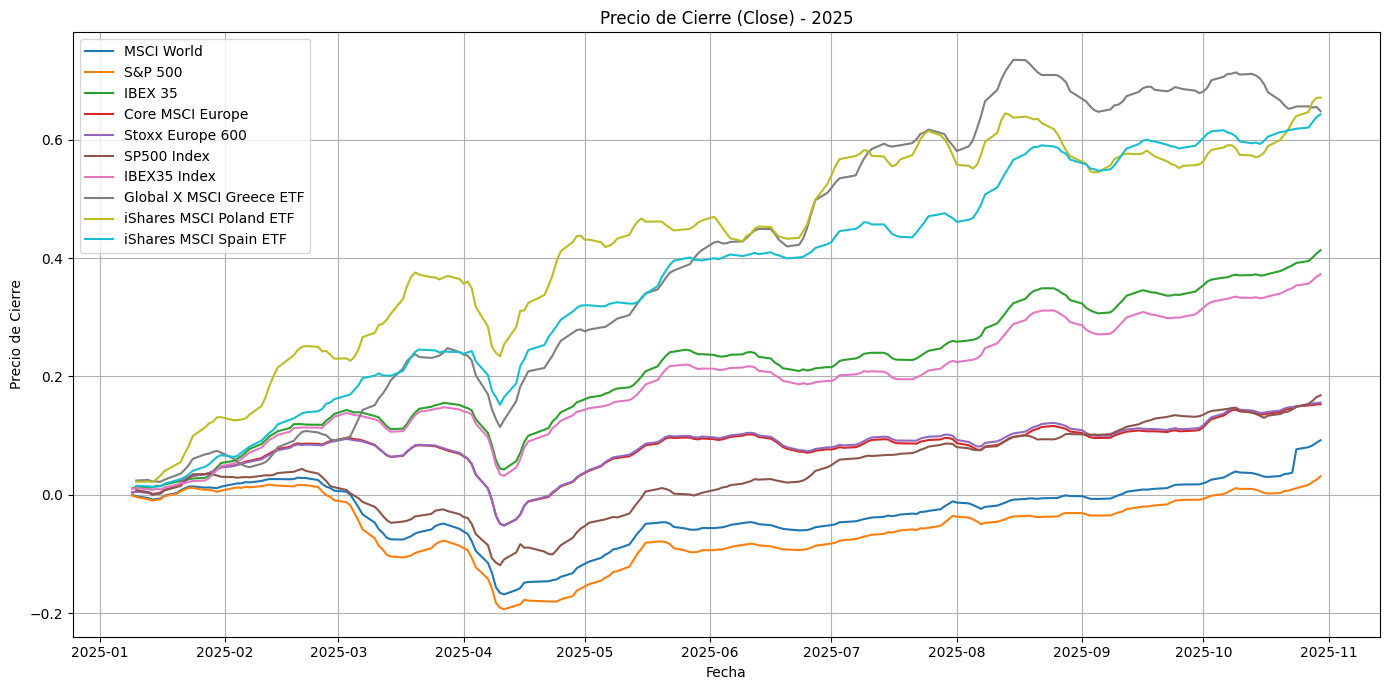

In [57]:
plt.figure(figsize=(14, 7))

for ticker, data in index_hist_df.items():
    plt.plot(data.index, data["Cumulative Return"].rolling(window=5).mean(), label=ticker)

plt.title("Precio de Cierre (Close) - 2025")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

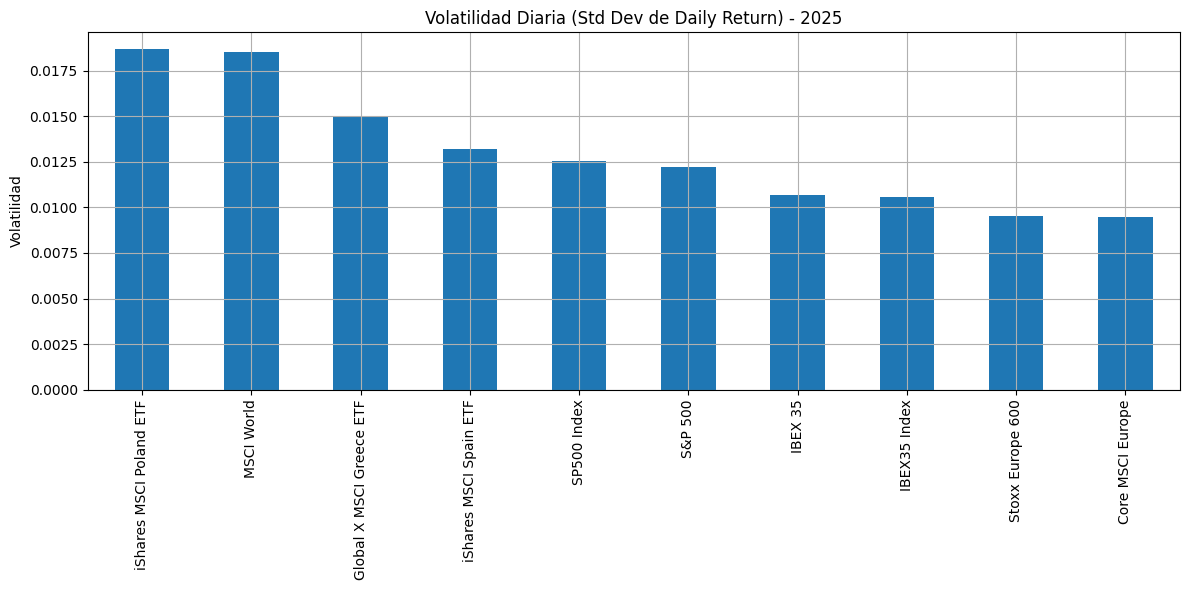

In [58]:
volatilities = {
    ticker: data["Daily Return"].std() for ticker, data in index_hist_df.items()
}

# Convertir a DataFrame y graficar
vol_df = pd.DataFrame.from_dict(volatilities, orient='index', columns=["Volatilidad"])
vol_df.sort_values("Volatilidad", ascending=False).plot(kind='bar', figsize=(12, 6), legend=False)

plt.title("Volatilidad Diaria (Std Dev de Daily Return) - 2025")
plt.ylabel("Volatilidad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
index_analysed_df

NameError: name 'index_analysed_df' is not defined

In [ ]:
start_period = datetime(2024,5,1)
end_period =  datetime(2025,9,11)

tickers_portafolio = {
    "GOOG": "Alphabet (Google)",
    "AMZN": "Amazon",
    #"ASTS": "AST SpaceMobile",
    "BRK-B": "Berkshire Hathaway B",
    "IWDA.AS": "MSCI World (iShares)",
    "CSPX.AS": "S&P 500 (iShares)",
    "HUBS": "HubSpot",
    "IAG.MC": "IAG (Iberia)",
    "CS1.PA": "CAC 40 / IBEX ETF",
    "ITX.MC": "Inditex",
    "MSFT": "Microsoft",
    "NVDA": "NVIDIA",
    "SNY": "Sanofi",
    "UNH": "UnitedHealth",
    "^GSPC": "benchmark_sp500",
    "^IBEX": "benchmark_ibex35",
}

bechmark_sp500 = call_yf_api_historic(start_period, end_period, '^GSPC')
portafolio_hist_df = extraction_historic(start_period, end_period, tickers_portafolio)
portafolio_analysed_df = analysis_stock_hist(portafolio_hist_df, tickers_portafolio, bechmark_sp500)

In [ ]:
portafolio_analysed_df

In [ ]:
plt.figure(figsize=(14, 7))

for ticker, data in portafolio_hist_df.items():
    plt.plot(data.index, data["Cumulative Return"], label=ticker)

plt.title("Precio de Cierre (Close) - 2025")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
volatilities = {
    ticker: data["Daily Return"].std() for ticker, data in portafolio_hist_df.items()
}

# Convertir a DataFrame y graficar
vol_df = pd.DataFrame.from_dict(volatilities, orient='index', columns=["Volatilidad"])
vol_df.sort_values("Volatilidad", ascending=False).plot(kind='bar', figsize=(12, 6), legend=False)

plt.title("Volatilidad Diaria (Std Dev de Daily Return) - 2025")
plt.ylabel("Volatilidad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm

def compute_alpha_beta(stock_data, benchmark_data):
    """
    Calcula Alpha y Beta de un activo respecto a un benchmark.
    stock_data y benchmark_data deben ser Series con retornos diarios (%).
    """
    # Alinear índices de fechas
    data = pd.concat([stock_data, benchmark_data], axis=1).dropna()
    stock_returns = data.iloc[:, 0]
    benchmark_returns = data.iloc[:, 1]

    # Regresión lineal: stock = alpha + beta * benchmark
    X = sm.add_constant(benchmark_returns)
    model = sm.OLS(stock_returns, X).fit()
    alpha, beta = model.params

    return alpha, beta

In [ ]:
stock_data = portafolio_hist_df['S&P 500 (iShares)']["Daily Return"]
benchmark_data = portafolio_hist_df['benchmark_sp500']["Daily Return"]

In [ ]:
compute_alpha_beta(portafolio_hist_df['Alphabet (Google)']["Daily Return"], portafolio_hist_df['benchmark_sp500']["Daily Return"])

In [ ]:
stock_data = ibex35_df['Banco Sabadell']["Daily Return"]
benchmark_data = bechmark_ibex35["Daily Return"]

data = pd.merge(
        stock_data.rename("stock"),
        benchmark_data.rename("benchmark"),
        left_index=True,
        right_index=True,
        how="left"
    ).dropna()

stock_returns = data.iloc[:, 0]
benchmark_returns = data.iloc[:, 1]

# Regresión lineal: stock = alpha + beta * benchmark
X = sm.add_constant(benchmark_returns)
model = sm.OLS(stock_returns, X).fit()
alpha, beta = model.params

In [ ]:
plt.scatter(benchmark_returns, stock_returns, color='blue', label='Data Points')

x_range = np.linspace(benchmark_returns.min(), benchmark_returns.max(), 100)
y_pred = model.params[0] + model.params[1] * x_range 

plt.plot(x_range, y_pred, color='red', label='Regression Line')
plt.xlabel('Independent Variable (X)')
plt.ylabel('Dependent Variable (Y)')
plt.title('OLS Regression Fit')
plt.legend()
plt.show()

In [ ]:
stock_data = sp500_df['Alphabet Inc. (Clase A)']["Close"]
benchmark_data = bechmark_sp500["Close"]

data = pd.merge(
        stock_data.rename("stock"),
        benchmark_data.rename("benchmark"),
        left_index=True,
        right_index=True,
        how="left"
    ).dropna()

stock_returns = data.iloc[:, 0].pct_change(1).dropna()
benchmark_returns = data.iloc[:, 1].pct_change(1).dropna()

# Regresión lineal: stock = alpha + beta * benchmark
X = sm.add_constant(benchmark_returns)
model = sm.OLS(stock_returns, X).fit()
alpha, beta = model.params

In [ ]:
plt.scatter(benchmark_returns, stock_returns, color='blue', label='Data Points')

x_range = np.linspace(benchmark_returns.min(), benchmark_returns.max(), 100)
y_pred = model.params[0] + model.params[1] * x_range 

plt.plot(x_range, y_pred, color='red', label='Regression Line')
plt.xlabel('Independent Variable (X)')
plt.ylabel('Dependent Variable (Y)')
plt.title('OLS Regression Fit')
plt.legend()
plt.show()

In [ ]:
subfolder = 'ibex35'

SUBFOLDER_DIR = os.path.join(DATA_DIR, subfolder)

def save_extraction_historic_parquet(data_his, path="data_historic"):
    os.makedirs(SUBFOLDER_DIR, exist_ok=True)
    for name, df in ibex35_df.items():
        df['share_name'] = name
        filename = name.lower().replace(' ', '_')
        df.to_parquet(f"{SUBFOLDER_DIR}//{filename}.parquet", index=True)


In [ ]:
save_extraction_historic_parquet(ibex35_df, SUBFOLDER_DIR)

In [ ]:
df_ibex_his = load_extraction_historic_parquet(SUBFOLDER_DIR)